# Baseline Model:


## Decision Tree Classifer

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.datasets import load_iris

%matplotlib inline

In [53]:
#Load in the dataset
diabetes_df = pd.read_csv('cleaned_diabetes_data.csv', index_col=0)

In [54]:
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,Otherwise
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,No,No,Yes,Otherwise
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,No,Steady,No,No,No,No,No,Ch,Yes,Otherwise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,No,Steady,No,No,No,No,No,Ch,Yes,Otherwise
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,No,Steady,No,No,No,No,No,No,Yes,Otherwise
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise


In [55]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import confusion_matrix


#Feature Selection
X = diabetes_df.drop(['readmitted'], axis=1)
y= diabetes_df['readmitted']


#Label encode target variable 'y' into numerics
labenc = LabelEncoder()
y = labenc.fit_transform(y)


In [56]:
#Do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

In [57]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    
    #create unique column names by prefixing with feature name
    ohe_column_names = [f'{feature_name}_{category}' for category in ohe.categories_[0]]
    ohe_df = pd.DataFrame(feature_array, columns=ohe_column_names, index=X.index)

    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [58]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [59]:
categorical_feature_names = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id','payer_code', 'medical_specialty','diag_1', 'diag_2', 'diag_3','max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide','citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

encoders = {}

#Encode X_train and store encoders
for categorical_feature in categorical_feature_names:
    ohe,X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe



In [60]:
encoders

{'race': OneHotEncoder(handle_unknown='ignore'),
 'gender': OneHotEncoder(handle_unknown='ignore'),
 'age': OneHotEncoder(handle_unknown='ignore'),
 'admission_type_id': OneHotEncoder(handle_unknown='ignore'),
 'discharge_disposition_id': OneHotEncoder(handle_unknown='ignore'),
 'admission_source_id': OneHotEncoder(handle_unknown='ignore'),
 'payer_code': OneHotEncoder(handle_unknown='ignore'),
 'medical_specialty': OneHotEncoder(handle_unknown='ignore'),
 'diag_1': OneHotEncoder(handle_unknown='ignore'),
 'diag_2': OneHotEncoder(handle_unknown='ignore'),
 'diag_3': OneHotEncoder(handle_unknown='ignore'),
 'max_glu_serum': OneHotEncoder(handle_unknown='ignore'),
 'A1Cresult': OneHotEncoder(handle_unknown='ignore'),
 'metformin': OneHotEncoder(handle_unknown='ignore'),
 'repaglinide': OneHotEncoder(handle_unknown='ignore'),
 'nateglinide': OneHotEncoder(handle_unknown='ignore'),
 'chlorpropamide': OneHotEncoder(handle_unknown='ignore'),
 'glimepiride': OneHotEncoder(handle_unknown='igno

In [61]:
def encode_and_concat_feature_test(X_test, feature_name, ohe):
    """
    Helper function for transforming test data. It takes in the full X_test dataframe,
    the feature name, and the already fitted encoder from X_train. Returns the transformed
    X_test with that feature encoded into multiple columns of 1s and 0s.
    """
    #Create new one-hot encoded df for the feature using the fitted encoder from X_train
    single_feature_df = X_test[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()

    #Ensure column names have same prefix structure as in X train
    ohe_column_names = [f'{feature_name}_{category}' for category in ohe.categories_[0]]
    ohe_df = pd.DataFrame(feature_array, columns = ohe_column_names, index=X_test.index)

    #Drop the old feature from X_test and concat the new one-hot encoded df
    X_test = X_test.drop(feature_name, axis=1)
    X_test = pd.concat([X_test, ohe_df], axis=1)
    
    return X_test

# Encode X_test using the fitted encoders
for categorical_feature in categorical_feature_names:
    X_test = encode_and_concat_feature_test(X_test, categorical_feature, encoders[categorical_feature])


Check encoding

In [62]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
29262,1,36,1,24,0,0,1,4,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
54052,8,49,0,10,1,0,0,5,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
93790,3,4,0,20,2,0,1,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
66811,2,53,0,12,0,0,0,6,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
6103,5,44,4,49,0,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49643,1,3,0,7,0,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
7670,9,48,6,33,0,0,0,8,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
77026,6,29,1,14,0,0,0,4,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
921,7,69,1,23,0,0,0,9,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [63]:
X_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
80578,6,60,2,21,1,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
60241,2,32,4,13,0,0,0,9,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
68768,2,20,0,12,0,0,0,5,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
47021,4,35,0,21,0,0,0,5,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
80121,4,67,0,12,1,0,0,7,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6829,7,42,3,20,0,0,0,6,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
46177,6,18,2,16,0,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
16916,2,40,2,10,0,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
64743,3,9,0,18,42,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [64]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [65]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [66]:
X_train.shape, X_test.shape

((52479, 2312), (17494, 2312))

# Building the Classifier

I am using a Decision Tree Classifier because it is best suited for datasets with lots of categorical features and for imbalanced datasets. I will use a max_depth of 10 to prevent overfitting the data. I will also set the class weight to be balanced so that the model isn't biased towards the majority class.

In [67]:
#Initialize the decision tree
tree_classifer = DecisionTreeClassifier(criterion='gini',splitter ='best',random_state=1000, max_depth = 10, class_weight= 'balanced' )

#fit it to the training data
tree_classifer.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=1000)

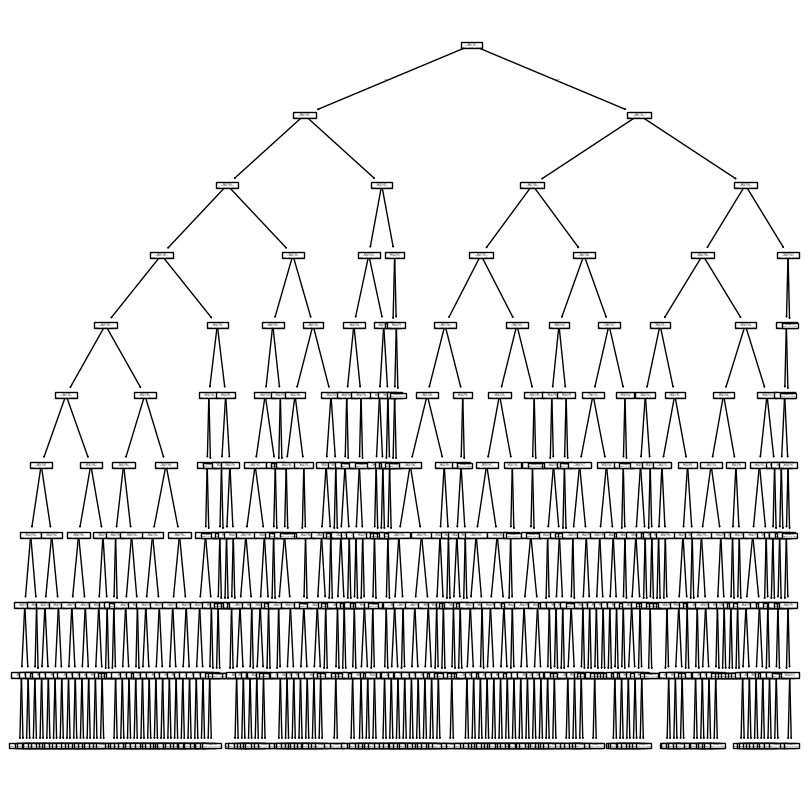

In [68]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_classifer, ax=ax);

## Evaluating the Classifier

In [69]:
#get predictions
y_pred = tree_classifer.predict(X_test)

cfmat = confusion_matrix(y_test,y_pred, labels=tree_classifer.classes_)


In [70]:
y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [71]:
cfmat

array([[ 915,  696],
       [6679, 9204]])

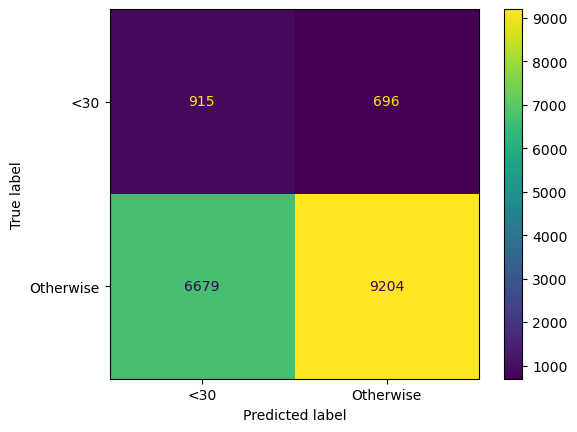

In [72]:

ConfusionMatrixDisplay.from_estimator(tree_classifer, X_test, y_test, display_labels=['<30', 'Otherwise']);

It looks like the model is performing pretty satisfactory. There are a lot of false negatives and true positives. This isn't great because we want to be good at correctly predicting when it is negative (<30)

In [73]:
tn, fp, fn, tp = cfmat.flatten()

In [74]:
tn, fp, fn, tp

(915, 696, 6679, 9204)

In [75]:
from sklearn.metrics import precision_score, recall_score, f1_score

The model is good at correctly identifying positive instances ('Outcome') with minimal false positives.

In [76]:
precision = precision_score(y_test, y_pred)
precision

0.9296969696969697

The model is not effective at capturing the majority of positive cases. This is measured by false negatives. It is also not good at predicting true negatives. So overall it struggles to predict the minority class.

In [77]:
recall = recall_score(y_test, y_pred)
recall

0.5794875023610149

In [78]:
f1 = f1_score(y_test, y_pred)
f1

0.7139588100686499

In [79]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.57      0.20      1611
           1       0.93      0.58      0.71     15883

    accuracy                           0.58     17494
   macro avg       0.53      0.57      0.46     17494
weighted avg       0.86      0.58      0.67     17494



In [80]:
feat_importance = tree_classifer.tree_.compute_feature_importances(normalize=False)
feat_importance

array([3.86959593e-03, 4.29197120e-03, 1.79105539e-03, ...,
       3.35366258e-04, 6.37095468e-05, 8.46883966e-04])

Feature: 0, Score: 0.00387
Feature: 1, Score: 0.00429
Feature: 2, Score: 0.00179
Feature: 3, Score: 0.00315
Feature: 4, Score: 0.00009
Feature: 5, Score: 0.00079
Feature: 6, Score: 0.00937
Feature: 7, Score: 0.00311
Feature: 8, Score: 0.00017
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00047
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00038
Feature: 14, Score: 0.00013
Feature: 15, Score: 0.00034
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00023
Feature: 22, Score: 0.00050
Feature: 23, Score: 0.00006
Feature: 24, Score: 0.00018
Feature: 25, Score: 0.00009
Feature: 26, Score: 0.00011
Feature: 27, Score: 0.00010
Feature: 28, Score: 0.00024
Feature: 29, Score: 0.00033
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00026
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.01303
Fe

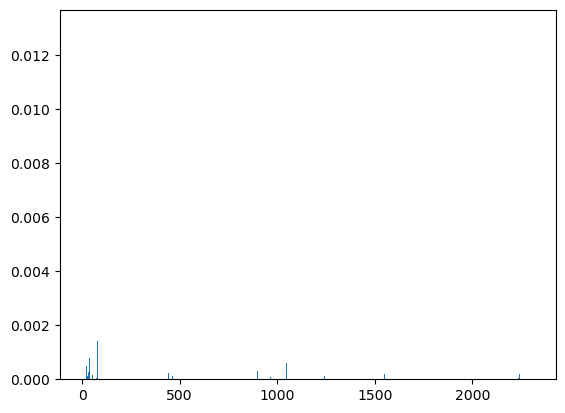

In [81]:
for i, v in enumerate(feat_importance):
    print(f'Feature: {i}, Score: {v:.5f}')
plt.bar([x for x in range(len(feat_importance))], feat_importance)
plt.show()

These features are very small, so it is difficult for us to really understand the power they have individually. It also may be misleading us to think that none of these weights have power. We would benefit from feature reduction.

In [82]:
classes = labenc.inverse_transform(y)

In [83]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [84]:
classes

array(['Otherwise', 'Otherwise', 'Otherwise', ..., 'Otherwise',
       'Otherwise', 'Otherwise'], dtype=object)

## Hyperparameter Tuning

- Lowering max depth to 7

In [85]:
#Initialize the decision tree
tree_classifer = DecisionTreeClassifier(criterion='gini',splitter ='best',random_state=1000,
max_depth = 7, class_weight= 'balanced')

#fit it to the training data
tree_classifer.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=7, random_state=1000)

In [86]:
#get predictions
y_pred = tree_classifer.predict(X_test)

cfmat = confusion_matrix(y_test,y_pred, labels=tree_classifer.classes_)


In [87]:
cfmat

array([[  849,   762],
       [ 5511, 10372]])

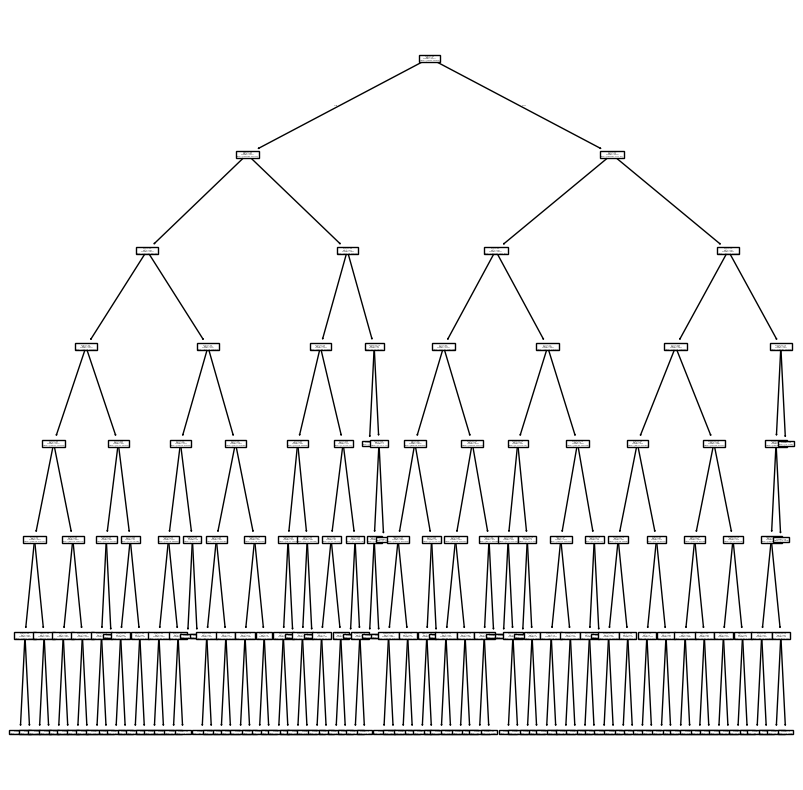

In [88]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_classifer, ax=ax)
plt.savefig('Baseline_Model.png')

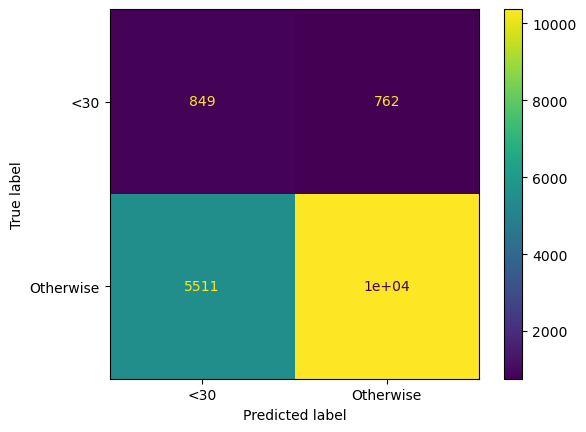

In [89]:

ConfusionMatrixDisplay.from_estimator(tree_classifer, X_test, y_test, display_labels=['<30', 'Otherwise']);

plt.savefig('Baseline_CFM.png')

In [90]:
y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [91]:
cfmat

array([[  849,   762],
       [ 5511, 10372]])

In [92]:
precision = precision_score(y_test,y_pred)
precision

0.9315609843721933

In [93]:
recall = recall_score(y_test, y_pred)
recall

0.6530252471195618

In [94]:
f1= f1_score(y_test,y_pred)
f1


0.7678128585705297

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.53      0.21      1611
           1       0.93      0.65      0.77     15883

    accuracy                           0.64     17494
   macro avg       0.53      0.59      0.49     17494
weighted avg       0.86      0.64      0.72     17494



Overall, after tuning, the model got a little better at recall with little change in precision.

## Official Evaluation of Baseline Model

The baseline model is not very precise at accurately identifying when readmission is <30 days/when it is negative (0), which is the minority class. Meanwhile it performs very well when predicting the majority class accurately. 

This shows how decision trees are not the best at handling high dimensionality and class imbalance, causing it to overfit when there's noise and complexity.

# Next Steps..

In my next model, I want try using a logistic regression model.

Logistic regression will give a linear decision bounday and may handle the feature space more efficiently than a decision tree. Logistic regression will allow me to balance the class weights as well, but it might generalize better since it won't overfit as much as trees on minority samples.

Logistic regression might better capture the linear separates in the data and improve recall and precision for the minority class if combined with proper regularization and class weights.

If necessary, I can use L1 regularization to help reduce the feature space and get rid of any irrelevant features, which will be important for handling the high dimensionality. 
